## Introduction

**Project name:** Sentiment analysis for IMDB reviews <br>
Autor: Tomasz Ostaszewicz <br>
Implementation: pandas, matplotlib, scikit-learn, keras.

**Description:** This is sentiment analysis for IMDB reviews. The aim of the analysis is to predict if movie review form IMDB is positive or negative (binary classification problem). To predict sentiment different preprocessing schemes and machine learning and deep learning models were used, including:

1. Classical machine learning models:
    1. Data preprocessing: removing stop words, removing punctuation, expanding contractions, stemming.
    2. Model input data in the form of: Count variables, TFidf variables.
    2. Models: Logistic Regression, SVM, Random Forest, Naive Bayes, XGBoost.
2. Deep learning models:
    1. Data preprocessing: removing punctuation.
    2. Model input data in the form of: Embeddings (from Glove model).
    3. Models: Simple RNN, LSTM, LSTM Bidirectional, LSTM Bidirectional with dropout, GRU, GRU Bidirectional, GRU Bidirectional with dropout.

Conclusions of analysis are presented at the end of each section.

In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost.sklearn import XGBClassifier

import itertools
import os
import IPython

pd.set_option('display.max_rows', 1000)

## Downloading input data

Create directories for input and output data.

In [2]:
def create_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)
    return None

create_dir("01 Input data")
create_dir("02 Output data")

Download data manually from Kaggle into subfolder "01 Input data" created above.
Use this link to download data: https://www.kaggle.com/c/word2vec-nlp-tutorial/data
Two files are needed: labeledTrainData.tsv.zip, testData.tsv.zip
Extract those files into "01 Input data" subdirectory.
Names of extracted files are: labeledTrainData.tsv, testData.tsv

Download manually file glove.6B.zip with GloVe vectors into subfolder "01 Input data" created above. 
Use this link to download data: http://nlp.stanford.edu/data/glove.6B.zip
Extract file: glove.6B.300d.txt into "01 Input data" subdirectory.

## Input data analysis

Read data.

In [4]:
kaggle_input_data_train = pd.read_csv('01 Input data/labeledTrainData.tsv', sep='\t', index_col = 'id')
kaggle_input_data_test = pd.read_csv('01 Input data/testData.tsv', sep='\t', index_col = 'id')

In [5]:
kaggle_input_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 5814_8 to 8478_8
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


In [6]:
# Checking data types for train
print(kaggle_input_data_train.info())

# Checking individuals rows
print(kaggle_input_data_train.head(5))
print(kaggle_input_data_train.sample(5))
print(kaggle_input_data_train.tail(5))

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 5814_8 to 8478_8
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 585.9+ KB
None
        sentiment                                             review
id                                                                  
5814_8          1  With all this stuff going down at the moment w...
2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
7759_3          0  The film starts with a manager (Nicholas Bell)...
3630_4          0  It must be assumed that those who praised this...
9495_8          1  Superbly trashy and wondrously unpretentious 8...
         sentiment                                             review
id                                                                   
504_8            1  Okay, the recent history of Star Trek has not ...
7502_2           0  I have always liked Spike Lee's movies, but th...
29

In [7]:
# Checking data types for test
print(kaggle_input_data_test.info())

# Checking individuals rows
print(kaggle_input_data_test.head(5))
print(kaggle_input_data_test.sample(5))
print(kaggle_input_data_test.tail(5))

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 12311_10 to 11465_10
Data columns (total 1 columns):
review    25000 non-null object
dtypes: object(1)
memory usage: 390.6+ KB
None
                                                     review
id                                                         
12311_10  Naturally in a film who's main themes are of m...
8348_2    This movie is a disaster within a disaster fil...
5828_4    All in all, this is a movie for kids. We saw i...
7186_2    Afraid of the Dark left me with the impression...
12128_7   A very accurate depiction of small time mob li...
                                                    review
id                                                        
9842_7   This one of those social dramas that WB knew h...
5772_9   This zany film rivals the Ghost and Mr. Chicke...
5471_2   How can you go wrong with a film that mixes th...
7632_2   Sorry I couldn't be more expressive in my summ...
11706_2  I can't express enough ju

**Conclusions for reading from train and test data:**
1. reading from tsv files is correct
2. No null values in review and sentiment columns

Target variable distribution check.

In [9]:
print(kaggle_input_data_train.sentiment.value_counts())
print(kaggle_input_data_train.sentiment.value_counts(normalize=True))

1    12500
0    12500
Name: sentiment, dtype: int64
1    0.5
0    0.5
Name: sentiment, dtype: float64


Conclusion:
Target variable classes' share is 50%, 50%. No problem of imbalanced classes in data.

## Sample split

Assumptions about sample split:
1. Number of observations in training sample: 25 000
2. Split:
   a. 20 000 observations for training sample,
   b. 5 000 observations for hold-out sample
3. Training is done on 20 000 observations using 3-kfold cross-validation for classical models
4. Test dataset from kaggle: kaggle_input_data_test does not contain target variable. It be used as additional independent verification of a few best models

In [12]:
# Sample split with stratified splitting is done
X_train, X_test, y_train, y_test = train_test_split(kaggle_input_data_train.review, kaggle_input_data_train.sentiment, 
                                                    test_size=5000, random_state=123,
                                                   stratify=kaggle_input_data_train.sentiment)

In [13]:
print(y_train.shape, y_train.sum())
print(y_test.shape, y_test.sum())

(20000,) 10000
(5000,) 2500


## Data preprocessing

Assumption:
Data preprocessing is done on whole training sample as a separate step to speed-up cross-validation step
Data preprocessing - especially stemming is time consuming.

Create dict that will be used for expanding contractions.

In [15]:
# This contraction dict was copied from:
# https://gist.github.com/nealrs/96342d8231b75cf4bb82

contractons_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

Extend contraction dict by other types of quotes which are used in reviews.

In [16]:
contractons_dict_ext = {}
for k, v in contractons_dict.items():
    contractons_dict_ext[k] = v
    contractons_dict_ext[k.replace("'", "`")] = v
    contractons_dict_ext[k.replace("'", "´")] = v

In [17]:
def rep_contr(match):
    'Function expands contractions using dictionary: contractons_dict_ext'
    return contractons_dict_ext[match.group(0)]

In [66]:
class TextStemmer(TransformerMixin):
    def __init__(self, stemmer = 'nltk_porter_stemmer', stop_words_list=nltk.corpus.stopwords.words('english'), punctuation_list=string.punctuation, expand_contractions = True):
        self.params_ = {'stemmer': stemmer, 'stop_words_list': stop_words_list, 'punctuation_list': punctuation_list, 'expand_contractions': expand_contractions}
        
    def fit(self, X, y=None, **kwargs):
        return self
        
    def transform(self, X,  **kwargs):
        
        # make text lower case
        X = [text.lower() for text in X] 
        
        if self.params_['stemmer'] == None and self.params_['stop_words_list'] == None \
            and self.params_['punctuation_list'] == None \
            and (self.params_['expand_contractions'] == None or self.params_['expand_contractions'] == False):
            # if there aren't any transformations return X
                return X
        else:
            
            # expand contractions
            if not (self.params_['expand_contractions'] == None or self.params_['expand_contractions'] == False):
                X = [re.sub('|'.join(contractons_dict_ext.keys()), rep_contr, text) for text in X] 
            
            # split text to separate words and remove single quote sing (') if it is first letter in a word. Change words to lower case
            X =[[word[1:].lower() if word.startswith("'") else word.lower() for word in nltk.word_tokenize(text)] for text in X]            
            
          
            # remove punctuation
            if self.params_['punctuation_list'] != None:
                X = [[word for word in text if word not in self.params_['punctuation_list']] for text in X]
            
            # remove stopwords
            if self.params_['stop_words_list'] != None:
                X = [[word for word in text if word not in self.params_['stop_words_list']] for text in X]
                
            # use stemmer
            if self.params_['stemmer'] == 'nltk_porter_stemmer':
                stemmer = nltk.PorterStemmer()
                X = [[stemmer.stem(word) for word in text] for text in X]
            
            # put separate words together into text
            X = [" ".join(text) for text in X]
            
            return X

Define pipelines for data preprocessing.

In [19]:
pipe_dict_preproc_data = {}

stemmer_dict = {
               'expcontr_rempunc_remsw_stemmer' : TextStemmer(expand_contractions=True, punctuation_list=string.punctuation, stop_words_list=nltk.corpus.stopwords.words('english'), stemmer = 'nltk_porter_stemmer' ),
               'expcontr_norempunc_noremsw_nostemmer' : TextStemmer(expand_contractions=True, punctuation_list=None, stop_words_list=None, stemmer=None),
               'noexpcontr_norempunc_noremsw_nostemmer' : TextStemmer(expand_contractions=None, punctuation_list=None, stop_words_list=None, stemmer=None)
               }

vectorizer_dict = {
                  'countvect5000' : CountVectorizer(max_features=5000, min_df=0.001, max_df=0.5),
                  'countvect1000' : CountVectorizer(max_features=1000, min_df=0.001, max_df=0.5),
                  'tfidvect5000' : TfidfVectorizer(max_features=5000, min_df=0.001, max_df=0.5),
                  'tfidvect1000' : TfidfVectorizer(max_features=1000, min_df=0.001, max_df=0.5)
                  }

for stemmer_key, stemmer_obj in stemmer_dict.items():
    for vectorizer_key, vectorizer_obj in vectorizer_dict.items():
        
        pipe_key = stemmer_key + '_' + vectorizer_key
        pipe = Pipeline([('stemmer', stemmer_obj), ('vectorizer', vectorizer_obj)])
        pipe_dict_preproc_data[pipe_key] = pipe


# Example of manual definition for dict: pipe_dict_preproc_data definition (above loop is used for convenience)
# pipe_key = 'stemmer_sw_punc_tfidvect5000'
# pipe = Pipeline([('stemmer', TextStemmer(stemmer=None)), ('vectorizer', TfidfVectorizer(max_features=5000, min_df=0.001, max_df=0.5))])
# pipe_dict_preproc_data[pipe_key] = pipe

Preprocess data using pipelines defined above to the form to be used in model estimation.

In [20]:
X_train_dict_preprocessed = {k : v.fit_transform(X_train) for (k, v) in pipe_dict_preproc_data.items()}
X_test_dict_preprocessed = {k : v.transform(X_test) for (k, v) in pipe_dict_preproc_data.items()}

## Classic model estimation setting

Define dictionaries to store estimated models.

In [21]:
gs_dict_gs = {}
gs_dict_best_estimator = {}
gs_dict_best_estimator_measures = {}
df_dict_gs_detail_res = {}
df_classic_models_res = None

In [22]:
def run_grid_search(pipe_key, pipe, grid_params):
    'Function runs grid search and collects results'
    
    for data_key, X_train_preproc in X_train_dict_preprocessed.items():

        dict_key = data_key + ' & ' + pipe_key
        print("Estimating: ", data_key, pipe_key)

        grid_search = GridSearchCV(pipe, grid_params, n_jobs=-1, scoring={'accuracy_score' : 'accuracy', 'roc_auc_score': 'roc_auc' }, refit='accuracy_score', return_train_score=True)
        %timeit -r 1 grid_search.fit(X_train_preproc, y_train)

        # save grid search results
        gs_dict_gs[dict_key] = grid_search
        gs_dict_best_estimator[dict_key] = grid_search.best_estimator_
        gs_dict_best_estimator_measures[dict_key] = grid_search.best_score_
        
        df_dict_gs_detail_res[pipe_key] = detail_est_res_to_df(gs_dict_gs, pipe_key)
    
    IPython.display.display(df_dict_gs_detail_res[pipe_key])
    

In [23]:
def detail_est_res_to_df(dict_est_results, pipe_key, gs_dict_gs=gs_dict_gs):
    '''
    Function converts dictionary with grid search results to pandas data frame in order to 
    analyze grid search parameters vs model performance
    '''
    
    # filter input dictionary by pipe_key
    dict_est_results = {k : v for (k,v) in dict_est_results.items() if k.endswith('& ' + pipe_key) == True}
   
    df_list = []
    # for each gs result create data frame containing gs parameters and measures values
    for dict_key, gs_res in dict_est_results.items():
        df_list.append(
                pd.concat((
                    pd.Series([dict_key.split('&')[0].strip() for x in range(len(dict_est_results[dict_key].cv_results_['params']))], name='input_data'),
                    pd.Series([dict_key.split('&')[1].strip() for x in range(len(dict_est_results[dict_key].cv_results_['params']))], name='model_name'),
                    pd.DataFrame(dict_est_results[dict_key].cv_results_['params']), 
                    
                    pd.Series( [(0 if param != dict_est_results[dict_key].best_params_ else 1) \
                                for param in dict_est_results[dict_key].cv_results_['params']], name = 'best_param_ind' ),
                    
                    pd.Series(gs_dict_gs[dict_key].cv_results_['mean_train_accuracy_score'], name = 'mean_train_accuracy_score'),
                    pd.Series(gs_dict_gs[dict_key].cv_results_['mean_test_accuracy_score'], name = 'mean_test_accuracy_score'),
                    pd.Series(gs_dict_gs[dict_key].cv_results_['mean_train_accuracy_score'] - gs_dict_gs[dict_key].cv_results_['mean_test_accuracy_score'], name = 'mean_train_test_accuracy_score_dif'),
                    
                    pd.Series(gs_dict_gs[dict_key].cv_results_['mean_train_roc_auc_score'], name = 'mean_train_roc_auc_score'),
                    pd.Series(gs_dict_gs[dict_key].cv_results_['mean_test_roc_auc_score'], name = 'mean_test_roc_auc_score'),
                    pd.Series(gs_dict_gs[dict_key].cv_results_['mean_train_roc_auc_score'] - gs_dict_gs[dict_key].cv_results_['mean_test_roc_auc_score'], name = 'mean_train_test_roc_auc_score_dif')
                ),
                    axis=1))
    
    
    return pd.concat(df_list)

In [24]:
def est_res_to_df(dict_est_results):
    'Function converts dictionary with grid search results to pandas data frame'
    
    col_index = dict_est_results.keys()
    col_means_val = [v.best_score_ for v in dict_est_results.values()]
    col_best_params = [v.best_params_ for v in dict_est_results.values()]
    dict_index_best_param = {k: (v.cv_results_['params'].index(v.best_params_)) for k,v in gs_dict_gs.items()}
    
    
    col_train_acc_score = { k1 : gs_dict_gs[k1].cv_results_['mean_train_accuracy_score'][v1] for (k1 , v1) in dict_index_best_param.items()}
    col_test_acc_score = { k1 : gs_dict_gs[k1].cv_results_['mean_test_accuracy_score'][v1] for (k1 , v1) in dict_index_best_param.items()}

    col_train_roc_auc_score = { k1 : gs_dict_gs[k1].cv_results_['mean_train_roc_auc_score'][v1] for (k1 , v1) in dict_index_best_param.items()}
    col_test_roc_auc_score = { k1 : gs_dict_gs[k1].cv_results_['mean_test_roc_auc_score'][v1] for (k1 , v1) in dict_index_best_param.items()}
    
    df_est_results = pd.DataFrame(pd.Series(data=col_means_val, index = col_index, name='measure_value'))
    df_est_results=df_est_results.assign(input_data = df_est_results.index.str.extract('(.*)&.*', expand=False).get_values())
    df_est_results=df_est_results.assign(model_name = df_est_results.index.str.extract('.*&(.*)', expand=False).get_values())
    df_est_results=df_est_results.assign(best_params = col_best_params)
    df_est_results=df_est_results.assign(mean_train_accuracy_score = col_train_acc_score.values())
    df_est_results=df_est_results.assign(mean_test_accuracy_score = col_test_acc_score.values())
    df_est_results['mean_train_test_accuracy_score_dif'] = df_est_results['mean_train_accuracy_score'] - df_est_results['mean_test_accuracy_score']

    df_est_results=df_est_results.assign(mean_train_roc_auc_score = col_train_roc_auc_score.values())
    df_est_results=df_est_results.assign(mean_test_roc_auc_score = col_test_roc_auc_score.values())
    df_est_results['mean_train_test_auc_roc_score_dif'] = df_est_results['mean_train_roc_auc_score'] - df_est_results['mean_test_roc_auc_score']

    df_est_results.reset_index(inplace=True, drop=True)
    
    return df_est_results

## Logistic Regression

In [25]:
pipe_key = "LOG_REG"
pipe = Pipeline([('model', LogisticRegression())])
grid_params = [{'model__C':[0.01, 0.1, 1, 10], 'model__penalty':['l1', 'l2']}]

run_grid_search(pipe_key, pipe, grid_params)

pipe_key = "svd_LOG_REG"
pipe = Pipeline([('selection', TruncatedSVD()), ('model', LogisticRegression())])
grid_params = [{'selection__n_components':[10, 50, 100], 'model__C':[0.01, 0.1, 1, 10]}]

run_grid_search(pipe_key, pipe, grid_params)

Estimating:  expcontr_rempunc_remsw_stemmer_countvect5000 LOG_REG
16.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_countvect1000 LOG_REG
10 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect5000 LOG_REG
11.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect1000 LOG_REG
9.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect5000 LOG_REG
23.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect1000 LOG_REG
12.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect5000 LOG_REG
9.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect1000 LOG_REG
7.9 s 

,input_data,model_name,model__C,model__penalty,best_param_ind,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_roc_auc_score_dif
0,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,0.01,l1,0,0.799775,0.79505,0.004725,0.877755,0.873712,0.004044
1,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,0.01,l2,0,0.903300,0.86830,0.035000,0.965139,0.935509,0.029630
2,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,0.10,l1,0,0.886100,0.86030,0.025800,0.953777,0.930928,0.022849
3,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,0.10,l2,1,0.949750,0.86980,0.079950,0.988903,0.936589,0.052314
4,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,1.00,l1,0,0.973775,0.85445,0.119325,0.996387,0.924786,0.071601
5,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,1.00,l2,0,0.986775,0.84680,0.139975,0.998768,0.920843,0.077925
6,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,10.00,l1,0,0.999900,0.82585,0.174050,0.999999,0.898399,0.101599
7,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,10.00,l2,0,0.999550,0.82765,0.171900,0.999985,0.903264,0.096722
0,expcontr_rempunc_remsw_stemmer_countvect1000,LOG_REG,0.01,l1,0,0.799775,0.79505,0.004725,0.877757,0.873712,0.004044
1,expcontr_rempunc_remsw_stemmer_countvect1000,LOG_REG,0.01,l2,0,0.872725,0.85225,0.020475,0.942552,0.923501,0.019051


Estimating:  expcontr_rempunc_remsw_stemmer_countvect5000 svd_LOG_REG
35.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_countvect1000 svd_LOG_REG
21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect5000 svd_LOG_REG
30.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect1000 svd_LOG_REG
20.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect5000 svd_LOG_REG
33.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect1000 svd_LOG_REG
20.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect5000 svd_LOG_REG
28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_t

,input_data,model_name,model__C,selection__n_components,best_param_ind,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_roc_auc_score_dif
0,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,0.01,10,0,0.745125,0.74570,-5.748313e-04,0.817594,0.817552,0.000042
1,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,0.01,50,0,0.785800,0.78370,2.100044e-03,0.860090,0.857728,0.002362
2,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,0.01,100,0,0.815125,0.80965,5.475100e-03,0.889111,0.882858,0.006252
3,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,0.10,10,0,0.746375,0.74615,2.253725e-04,0.818399,0.818017,0.000382
4,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,0.10,50,0,0.787000,0.78260,4.400115e-03,0.860586,0.856887,0.003699
5,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,0.10,100,1,0.815675,0.81225,3.425065e-03,0.891577,0.886049,0.005528
6,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,1.00,10,0,0.744725,0.74410,6.252187e-04,0.817474,0.817204,0.000270
7,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,1.00,50,0,0.786100,0.78250,3.600093e-03,0.860886,0.857990,0.002896
8,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,1.00,100,0,0.814075,0.80765,6.425048e-03,0.887872,0.882896,0.004976
9,expcontr_rempunc_remsw_stemmer_countvect5000,svd_LOG_REG,10.00,10,0,0.743000,0.74520,-2.199789e-03,0.815819,0.815042,0.000777


## SVM

In [26]:
# Due to long computation time SVM model was calculated only on variables resulting from SVD decomposition
pipe_key = "svm"
pipe = Pipeline([('selection', TruncatedSVD()), ('model', SVC())])
grid_params = [{'selection__n_components':[500], 'model__C':[ 20, 50, 100]}]

run_grid_search(pipe_key, pipe, grid_params)

Estimating:  expcontr_rempunc_remsw_stemmer_countvect5000 svm
27min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_countvect1000 svm
27min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect5000 svm
24min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect1000 svm
21min 55s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect5000 svm
30min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect1000 svm
33min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect5000 svm
24min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect1000 svm
22min 14s ± 0 ns

,input_data,model_name,model__C,selection__n_components,best_param_ind,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_roc_auc_score_dif
0,expcontr_rempunc_remsw_stemmer_countvect5000,svm,20,500,1,0.939850,0.85445,0.085400,0.981929,0.929729,0.052200
1,expcontr_rempunc_remsw_stemmer_countvect5000,svm,50,500,0,0.967000,0.85200,0.115000,0.992573,0.926204,0.066369
2,expcontr_rempunc_remsw_stemmer_countvect5000,svm,100,500,0,0.983100,0.84690,0.136200,0.997317,0.921296,0.076021
0,expcontr_rempunc_remsw_stemmer_countvect1000,svm,20,500,1,0.937500,0.84430,0.093200,0.980648,0.921670,0.058979
1,expcontr_rempunc_remsw_stemmer_countvect1000,svm,50,500,0,0.966300,0.84005,0.126250,0.992439,0.917875,0.074565
2,expcontr_rempunc_remsw_stemmer_countvect1000,svm,100,500,0,0.983375,0.83370,0.149675,0.997541,0.912902,0.084639
0,expcontr_rempunc_remsw_stemmer_tfidvect5000,svm,20,500,0,0.861625,0.85200,0.009625,0.939461,0.931842,0.007619
1,expcontr_rempunc_remsw_stemmer_tfidvect5000,svm,50,500,0,0.873125,0.86170,0.011425,0.945873,0.937084,0.008789
2,expcontr_rempunc_remsw_stemmer_tfidvect5000,svm,100,500,1,0.878700,0.86335,0.015350,0.948156,0.938365,0.009791
0,expcontr_rempunc_remsw_stemmer_tfidvect1000,svm,20,500,0,0.857100,0.84800,0.009100,0.933552,0.925409,0.008143


## Random Forest

In [27]:
pipe_key = "random_forest"
pipe = Pipeline([('model', RandomForestClassifier())])
grid_params = [{'model__min_samples_leaf':[1, 2, 5, 10, 20, 50], 'model__n_estimators':[10, 100, 500, 1000]}]

run_grid_search(pipe_key, pipe, grid_params)

Estimating:  expcontr_rempunc_remsw_stemmer_countvect5000 random_forest
31min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_countvect1000 random_forest
33min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect5000 random_forest
30min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect1000 random_forest
33min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect5000 random_forest
25min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect1000 random_forest
35min 42s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect5000 random_forest
34min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  

,input_data,model_name,model__min_samples_leaf,model__n_estimators,best_param_ind,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_roc_auc_score_dif
0,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,1,10,0,0.992750,0.76690,0.225850,0.999758,0.850354,0.149404
1,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,1,100,0,1.000000,0.84075,0.159250,1.000000,0.917191,0.082809
2,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,1,500,0,1.000000,0.84760,0.152400,1.000000,0.922964,0.077036
3,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,1,1000,1,1.000000,0.85015,0.149850,1.000000,0.923747,0.076253
4,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,2,10,0,0.964325,0.78900,0.175325,0.994131,0.868138,0.125993
5,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,2,100,0,0.991775,0.84035,0.151425,0.999461,0.917114,0.082348
6,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,2,500,0,0.993025,0.84565,0.147375,0.999555,0.922604,0.076952
7,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,2,1000,0,0.993000,0.84820,0.144800,0.999578,0.923442,0.076136
8,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,5,10,0,0.901175,0.80105,0.100125,0.964825,0.881389,0.083436
9,expcontr_rempunc_remsw_stemmer_countvect5000,random_forest,5,100,0,0.939600,0.83970,0.099900,0.985635,0.918184,0.067451


## Naive Bayes

In [28]:
pipe_key = "naive_bayes"
pipe = Pipeline([('model', MultinomialNB())])
grid_params = [{'model__alpha':[0, 1, 10, 50]}]

run_grid_search(pipe_key, pipe, grid_params)


Estimating:  expcontr_rempunc_remsw_stemmer_countvect5000 naive_bayes
6.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_countvect1000 naive_bayes
6.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect5000 naive_bayes
6.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect1000 naive_bayes
5.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect5000 naive_bayes
6.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect1000 naive_bayes


H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


6.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect5000 naive_bayes
6.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect1000 naive_bayes


H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


6.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  noexpcontr_norempunc_noremsw_nostemmer_countvect5000 naive_bayes


H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


6.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  noexpcontr_norempunc_noremsw_nostemmer_countvect1000 naive_bayes


H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
H:\Programy\Miniconda3\envs\env1\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


6.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  noexpcontr_norempunc_noremsw_nostemmer_tfidvect5000 naive_bayes
6.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  noexpcontr_norempunc_noremsw_nostemmer_tfidvect1000 naive_bayes
5.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


,input_data,model_name,model__alpha,best_param_ind,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_roc_auc_score_dif
0,expcontr_rempunc_remsw_stemmer_countvect5000,naive_bayes,0,0,0.868475,0.84580,0.022675,0.932677,0.910859,0.021818
1,expcontr_rempunc_remsw_stemmer_countvect5000,naive_bayes,1,0,0.868375,0.84730,0.021075,0.932403,0.912028,0.020375
2,expcontr_rempunc_remsw_stemmer_countvect5000,naive_bayes,10,1,0.866275,0.84820,0.018075,0.931337,0.913464,0.017874
3,expcontr_rempunc_remsw_stemmer_countvect5000,naive_bayes,50,0,0.861100,0.84635,0.014750,0.927972,0.913695,0.014277
0,expcontr_rempunc_remsw_stemmer_countvect1000,naive_bayes,0,0,0.839700,0.83110,0.008600,0.907927,0.900975,0.006953
1,expcontr_rempunc_remsw_stemmer_countvect1000,naive_bayes,1,0,0.839775,0.83110,0.008675,0.907914,0.900967,0.006946
2,expcontr_rempunc_remsw_stemmer_countvect1000,naive_bayes,10,1,0.839975,0.83125,0.008725,0.907782,0.900916,0.006865
3,expcontr_rempunc_remsw_stemmer_countvect1000,naive_bayes,50,0,0.838500,0.83100,0.007500,0.907194,0.900549,0.006646
0,expcontr_rempunc_remsw_stemmer_tfidvect5000,naive_bayes,0,0,0.876150,0.84480,0.031350,0.946241,0.919290,0.026951
1,expcontr_rempunc_remsw_stemmer_tfidvect5000,naive_bayes,1,0,0.875375,0.84780,0.027575,0.946018,0.923763,0.022255


## XGBoost

In [29]:
pipe_key = "xgboost"
pipe = Pipeline([('model', XGBClassifier())])
grid_params = [{'model__n_estimators':[100, 500, 1000], 'model__learning_rate': [0.05, 0.1, 0.3, 1]}]

run_grid_search(pipe_key, pipe, grid_params)

Estimating:  expcontr_rempunc_remsw_stemmer_countvect5000 xgboost
9min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_countvect1000 xgboost
7min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect5000 xgboost
31min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_rempunc_remsw_stemmer_tfidvect1000 xgboost
19min 15s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect5000 xgboost
11min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_countvect1000 xgboost
7min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvect5000 xgboost
31min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Estimating:  expcontr_norempunc_noremsw_nostemmer_tfidvec

,input_data,model_name,model__learning_rate,model__n_estimators,best_param_ind,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_roc_auc_score_dif
0,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.05,100,0,0.796425,0.78355,0.012875,0.884954,0.869196,0.015758
1,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.05,500,0,0.878100,0.83805,0.040050,0.953919,0.919009,0.034910
2,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.05,1000,0,0.913825,0.85365,0.060175,0.975433,0.930904,0.044529
3,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.10,100,0,0.831075,0.81105,0.020025,0.916464,0.894232,0.022233
4,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.10,500,0,0.913075,0.85285,0.060225,0.975285,0.929892,0.045393
5,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.10,1000,0,0.949950,0.86620,0.083750,0.990589,0.937280,0.053309
6,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.30,100,0,0.885550,0.84210,0.043450,0.957589,0.919789,0.037801
7,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.30,500,0,0.968550,0.86545,0.103100,0.995572,0.937491,0.058080
8,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,0.30,1000,1,0.991600,0.86765,0.123950,0.999524,0.938774,0.060750
9,expcontr_rempunc_remsw_stemmer_countvect5000,xgboost,1.00,100,0,0.930750,0.83475,0.096000,0.981183,0.912156,0.069027


## Summarize classic models

In [30]:
df_classic_models_res = est_res_to_df(gs_dict_gs)
df_classic_models_res.to_csv("02 Output data/df_classic_models_est_results.csv")
df_classic_models_res

,measure_value,input_data,model_name,best_params,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_auc_roc_score_dif
0,0.86980,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.949750,0.86980,0.079950,0.988903,0.936589,0.052314
1,0.85295,expcontr_rempunc_remsw_stemmer_countvect1000,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l1'}",0.874775,0.85295,0.021825,0.943927,0.925293,0.018634
2,0.87625,expcontr_rempunc_remsw_stemmer_tfidvect5000,LOG_REG,"{'model__C': 1, 'model__penalty': 'l2'}",0.917400,0.87625,0.041150,0.973973,0.946348,0.027625
3,0.85575,expcontr_rempunc_remsw_stemmer_tfidvect1000,LOG_REG,"{'model__C': 1, 'model__penalty': 'l2'}",0.879025,0.85575,0.023275,0.950352,0.931749,0.018604
4,0.87195,expcontr_norempunc_noremsw_nostemmer_countvect...,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.954975,0.87195,0.083025,0.991101,0.940112,0.050989
5,0.85325,expcontr_norempunc_noremsw_nostemmer_countvect...,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l1'}",0.874900,0.85325,0.021650,0.944810,0.926810,0.018001
6,0.87735,expcontr_norempunc_noremsw_nostemmer_tfidvect5...,LOG_REG,"{'model__C': 1, 'model__penalty': 'l2'}",0.920300,0.87735,0.042950,0.975060,0.948393,0.026667
7,0.85695,expcontr_norempunc_noremsw_nostemmer_tfidvect1...,LOG_REG,"{'model__C': 1, 'model__penalty': 'l1'}",0.879350,0.85695,0.022400,0.949541,0.932546,0.016994
8,0.87300,noexpcontr_norempunc_noremsw_nostemmer_countve...,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.955025,0.87300,0.082025,0.991178,0.940026,0.051152
9,0.85390,noexpcontr_norempunc_noremsw_nostemmer_countve...,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l1'}",0.874450,0.85390,0.020550,0.944638,0.926211,0.018427


Show 10 best results.

In [129]:
df_classic_models_res.sort_values('mean_test_accuracy_score', ascending=False).head(10)

,measure_value,input_data,model_name,best_params,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_test_accuracy_score_dif,mean_train_roc_auc_score,mean_test_roc_auc_score,mean_train_test_auc_roc_score_dif
10,0.87850,noexpcontr_norempunc_noremsw_nostemmer_tfidvec...,LOG_REG,"{'model__C': 1, 'model__penalty': 'l2'}",0.920250,0.87850,0.041750,0.975187,0.948453,0.026734
6,0.87735,expcontr_norempunc_noremsw_nostemmer_tfidvect5...,LOG_REG,"{'model__C': 1, 'model__penalty': 'l2'}",0.920300,0.87735,0.042950,0.975060,0.948393,0.026667
2,0.87625,expcontr_rempunc_remsw_stemmer_tfidvect5000,LOG_REG,"{'model__C': 1, 'model__penalty': 'l2'}",0.917400,0.87625,0.041150,0.973973,0.946348,0.027625
8,0.87300,noexpcontr_norempunc_noremsw_nostemmer_countve...,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.955025,0.87300,0.082025,0.991178,0.940026,0.051152
4,0.87195,expcontr_norempunc_noremsw_nostemmer_countvect...,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.954975,0.87195,0.083025,0.991101,0.940112,0.050989
68,0.87070,noexpcontr_norempunc_noremsw_nostemmer_countve...,xgboost,"{'model__learning_rate': 0.3, 'model__n_estima...",0.994900,0.87070,0.124200,0.999811,0.941696,0.058115
64,0.87040,expcontr_norempunc_noremsw_nostemmer_countvect...,xgboost,"{'model__learning_rate': 0.3, 'model__n_estima...",0.994825,0.87040,0.124425,0.999806,0.940958,0.058849
0,0.86980,expcontr_rempunc_remsw_stemmer_countvect5000,LOG_REG,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.949750,0.86980,0.079950,0.988903,0.936589,0.052314
30,0.86905,expcontr_norempunc_noremsw_nostemmer_tfidvect5...,svm,"{'model__C': 100, 'selection__n_components': 500}",0.883100,0.86905,0.014050,0.950675,0.940928,0.009747
34,0.86775,noexpcontr_norempunc_noremsw_nostemmer_tfidvec...,svm,"{'model__C': 100, 'selection__n_components': 500}",0.881775,0.86775,0.014025,0.950578,0.940872,0.009706


In [31]:
def create_df_dict_gs_detail_res2():
    'Function creates df with detail estimation results unified for all classical model types'
    
    df_dict_gs_detail_res2 = {}
    for model_id, df_res in df_dict_gs_detail_res.items():
        df = df_dict_gs_detail_res[model_id].reset_index()
        df_dict_gs_detail_res2[model_id]=df.melt(id_vars=['index', 'input_data', 'model_name', 'best_param_ind', 'mean_train_accuracy_score',\
               'mean_test_accuracy_score', 'mean_train_test_accuracy_score_dif',\
               'mean_train_roc_auc_score', 'mean_test_roc_auc_score',\
               'mean_train_test_roc_auc_score_dif'],
               var_name='Parameter_name', value_name='Parameter_value')
    df_detail_res = pd.concat(df_dict_gs_detail_res2.values(),axis=0)
    return df_detail_res

Save concatenated detail estimation results.

In [32]:
df_detail_res_to_csv = create_df_dict_gs_detail_res2()
df_detail_res_to_csv.to_csv("02 Output data/df_classic_models_est_results_details.csv", sep=";", decimal=',')

Save estimation results to files (without unification done above).

In [34]:
for model_id, df_res in df_dict_gs_detail_res.items():
    df_dict_gs_detail_res[model_id].to_csv("02 Output data/df_classic_models_est_results_details_" + model_id + ".csv", sep=";", decimal=',')

Model performance comparison.

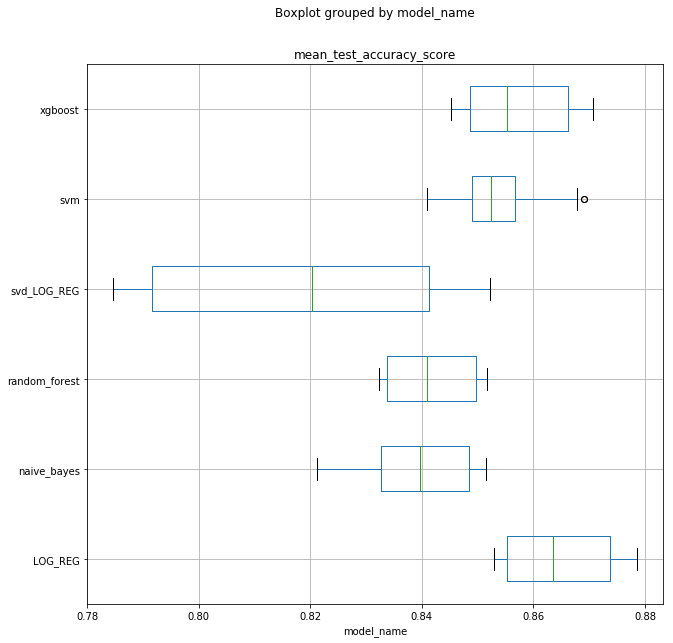

In [41]:
df_detail_res_to_plot = df_detail_res_to_csv[df_detail_res_to_csv.best_param_ind==1].sort_values(['mean_test_accuracy_score'], ascending = False)
df_detail_res_to_plot.boxplot(column='mean_test_accuracy_score', by='model_name', figsize=(10,10), vert=False)
plt.show()

### Conclusions for the plot above

The best model is Logistic Regression which is slightly surprising. XGBoost and SVM are slightly worse.
It is possible that better tuning of hyperparameters for XGBoost and SVM could result in better performance (at least on LR level)
Using SVD to preselect variables for Logistic Regression gives unsatisfactory results.
Logistic regression gives the best accuracy score (0.87850).

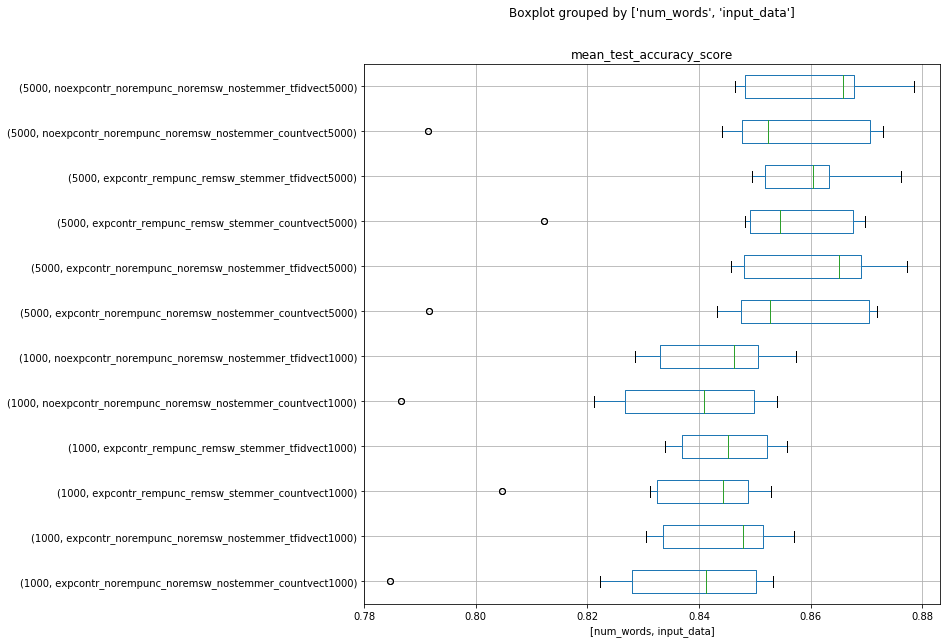

In [50]:
df_detail_res_to_plot2 = df_detail_res_to_plot
df_detail_res_to_plot2['num_words'] = df_detail_res_to_plot2.input_data.str[-4:]
df_detail_res_to_plot2.boxplot(column='mean_test_accuracy_score', by=['num_words', 'input_data'], figsize=(10,10), rot=0, vert=False)
plt.show()

### Conclusions

Data above are group by number of words (5000 - first part, 1000 word - second part)
Using 1000 words as a base for estimation gives noticeable worse result than estimation on 5000 words.
Preprocessing data (expanding contraction, removing punctuation and stop words and using stemmer) gives slightly worse performance than data which are not preprocessed in any way. In chart below TFIdf and Count Vectorizers interweave. It is noticeable that using count vectorizer give slightly worse performance than using TFidf Vectorizer.

## Recurrent Neural Networks

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, LSTM, GRU, GlobalAveragePooling1D, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import backend as K
from keras import regularizers

Using TensorFlow backend.


In [20]:
num_cores = 4

# use CPU or GPU
num_CPU = 1
num_GPU = 0 #set 1 if you want to run calculations on GPU

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [67]:
class Rnn_Tokenizer(TransformerMixin):
    'Assigns integers to words and creates integer sequences (by transform method)'
    
    def __init__(self, num_words = None, max_seq_length = None):
        self.num_words_ = num_words
        self.max_seq_length_ = max_seq_length
        
    def fit(self, X, max_seq_length = None):
        
        self.tokenizer = Tokenizer(num_words = self.num_words_)
        self.tokenizer.fit_on_texts(X)
        
        if self.max_seq_length_ == None:
            self.max_seq_length_ = max([len(l) for l in self.tokenizer.texts_to_sequences(X)])
        
        return self
        
    def transform(self, X, **kwargs):            
        int_text = self.tokenizer.texts_to_sequences(X)
        return pad_sequences(int_text, maxlen=self.max_seq_length_)
        
        

In [68]:
par_max_num_words = 200000 #parameter value indicates max number of words which is possible to be used in model estimation

Calculate maximum number of words in review (after removing punctuation) for concatenated train and test sets.

In [69]:
rnn_pipe = Pipeline([('nostemmer_nosw_punc', TextStemmer(stemmer=None, stop_words_list=None, punctuation_list=string.punctuation))
                     , ('rnn_tokenizer', Rnn_Tokenizer(num_words=par_max_num_words))
                     ])
rnn_pipe.fit_transform(np.concatenate((kaggle_input_data_train['review'].values, kaggle_input_data_test['review'].values)))
par_max_seq_length_calculated = rnn_pipe.steps[1][1].max_seq_length_
par_max_seq_length_calculated

2525

In [30]:
par_max_seq_length=400 #set manually maximum sequence length (=maximum number of words in review) to reduce computation time

### Read embeddings

Read embeddings and filter them by words which occur in reviews (train and test sets). This step creates two numpy arrays: emb_words (array of words), emb_vectors (array of embeddings values)

In [70]:
par_embedding_length = 300

with open('01 Input data/glove.6B.' + str(par_embedding_length) + 'd.txt', encoding="utf8") as f:
    i = 1
    emb_words = np.empty((par_max_num_words+1), dtype='object')
    emb_vectors = np.zeros((par_max_num_words+1, par_embedding_length))
    emb_words[0] = ''
    for line in f:

        line_list = line.split(' ')
        
        
        try:
            rnn_pipe.steps[1][1].tokenizer.word_index[line_list[0]]    
        except KeyError:
            pass
        else:
            if i <= par_max_num_words:
                emb_words[i] = line_list[0]
                emb_vectors[i] = line_list[1:]
            i = i + 1

Sample of first 1000 words in embeddings.

In [71]:
for i in range(min(1000, par_max_num_words)):
    print(emb_words[i])


the
of
to
and
in
a
's
for
that
on
is
was
said
with
he
as
it
by
at
from
his
an
be
has
are
have
but
were
not
this
who
they
had
i
which
will
their
or
its
one
after
new
been
also
we
would
two
more
'
first
about
up
when
year
there
all
out
she
other
people
n't
her
percent
than
over
into
last
some
government
time
you
years
if
no
world
can
three
do
president
only
state
million
could
us
most
against
so
them
what
him
united
during
before
may
since
many
while
where
states
because
now
city
made
like
between
did
just
national
day
country
under
such
second
then
company
group
any
through
china
four
being
down
war
back
off
south
american
minister
police
well
including
team
international
week
officials
still
both
even
high
part
told
those
end
former
these
make
billion
work
our
home
school
party
house
old
later
get
another
tuesday
news
long
five
called
1
wednesday
military
way
used
much
next
monday
thursday
friday
game
here
should
take
very
my
north
security
season
york
how
public
early
according
sever

Check which words are in reviews and aren't in embeddings.

In [72]:
words_in_reviews_not_in_emb = []
for word in rnn_pipe.steps[1][1].tokenizer.word_index.keys():
    if word not in emb_words:
        words_in_reviews_not_in_emb.append(word)

In [73]:
words_in_reviews_not_in_emb

['\x96',
 '\x97',
 'imho',
 'gypo',
 'feinstone',
 'hynkel',
 'zelah',
 'cheezy',
 'ossessione',
 'carface',
 "t'aime",
 "80's",
 'starewicz',
 'nazarin',
 'bolkan',
 'paperhouse',
 'trelkovsky',
 'sheeta',
 'hackenstein',
 'pazu',
 'slausen',
 "70's",
 'cassavettes',
 '£1',
 'mraovich',
 'brinke',
 'shepitko',
 'buttgereit',
 'mordrid',
 'polarisdib',
 'hahaha',
 'raisuli',
 'darkwolf',
 'todesking',
 'gorehounds',
 'conrack',
 'trivialboring',
 'xica',
 'fingersmith',
 'dialouge',
 'grisby',
 'mukhsin',
 'falon',
 'sakall',
 'sotnikov',
 'dominoe',
 'afroreggae',
 'demonicus',
 'pianiste',
 'toxie',
 'shax',
 'syberberg',
 'cringeworthy',
 'matuschek',
 'marylee',
 'grunnick',
 'hundstage',
 'louque',
 'stirba',
 'reccomend',
 'gammera',
 'gialli',
 'gymkata',
 'noroi',
 "60's",
 'everyones',
 "did'nt",
 'jox',
 'dinocroc',
 'protée',
 'completist',
 'gedren',
 'thalluri',
 'darvi',
 'soultaker',
 'galaxina',
 'pakeezah',
 'railly',
 'hitokiri',
 'gojoe',
 'maléfique',
 'digicorp',
 

Preliminary analysis indicated that:
1. words such as: "'real", "'love" that is  with single quote sign (') at the beginning appear in list
2. words such as: "it´s", "didn't", "don't", "i'm" that are shortcuts appear quite often


To address these issues TextStemmer class was extended so that:
Ad 1. Single quote sign (') appearing at the beginning of the word is removed
Ad 2. Common contractions are expanded to full words.
Preliminary list contained in total: 32832 words. List after applying steps 1. and 2. contains: 27947 words.
Usually words on the list below are spelling errors or uncommon words.

In [74]:
# Number of word in reviews but not in embeddings vector
len(words_in_reviews_not_in_emb)

27947

### Data preprocessing for RNN

Create Pipelines for data preprocessing.

In [75]:
dict_rnn_pipe = {}

text_stemmer_key = 'nostemmer_nosw_punc_expcontr'
text_stemmer_obj = TextStemmer(stemmer=None, stop_words_list=None, punctuation_list=string.punctuation, expand_contractions = True)


rnn_tokenizer_key = 'rnn_tokenizer_1000'
rnn_tokenizer_obj = Rnn_Tokenizer(num_words=1000, max_seq_length=par_max_seq_length)
rnn_pipe = Pipeline([(text_stemmer_key, text_stemmer_obj), (rnn_tokenizer_key, rnn_tokenizer_obj)])
dict_rnn_pipe[text_stemmer_key + '__' + rnn_tokenizer_key] = rnn_pipe


rnn_tokenizer_key = 'rnn_tokenizer_5000'
rnn_tokenizer_obj = Rnn_Tokenizer(num_words=5000, max_seq_length=par_max_seq_length)
rnn_pipe = Pipeline([(text_stemmer_key, text_stemmer_obj), (rnn_tokenizer_key, rnn_tokenizer_obj)])
dict_rnn_pipe[text_stemmer_key + '__' + rnn_tokenizer_key] = rnn_pipe


rnn_tokenizer_key = 'rnn_tokenizer_20000'
rnn_tokenizer_obj = Rnn_Tokenizer(num_words=20000, max_seq_length=par_max_seq_length)
rnn_pipe = Pipeline([(text_stemmer_key, text_stemmer_obj), (rnn_tokenizer_key, rnn_tokenizer_obj)])
dict_rnn_pipe[text_stemmer_key + '__' + rnn_tokenizer_key] = rnn_pipe

Run Pipelines for data preprocessing.

In [76]:
rnn_X_train_dict_preprocessed = {}
rnn_X_test_dict_preprocessed = {}

for pipe_key, pipe in dict_rnn_pipe.items():
    rnn_X_train_dict_preprocessed[pipe_key] = pipe.fit_transform(X_train)
    rnn_X_test_dict_preprocessed[pipe_key] = pipe.transform(X_test)

In [77]:
def create_embeddding_weights(tokenizer, emb_words, emb_vectors):
    '''
    Function creates embedding matrix to be used in Embedding layer and creates dictionary with
    words which do not have representation in embedding vector
    '''

    embeddings = np.zeros((tokenizer.num_words + 1, par_embedding_length))
    words_not_in_embeddings = {}
    
    for word, word_int in tokenizer.word_index.items():
        if word_int <= tokenizer.num_words:
            if np.nonzero(emb_words==word)[0].shape[0] == 0:
                words_not_in_embeddings[word] = word_int
            else:
                embeddings[word_int, :] = emb_vectors[np.nonzero(emb_words==word)[0]]
    return embeddings, words_not_in_embeddings

Create embedding matrices to be used in Embedding layer and create dictionaries with words which do not have representation in embedding vector.

In [78]:
rnn_X_train_embeddings = {}
rnn_X_test_embeddings = {}
rnn_X_train_words_not_in_embeddings = {}


for pipe_key, pipe in dict_rnn_pipe.items():
    
    tokenizer = dict_rnn_pipe[pipe_key].steps[1][1].tokenizer
    rv = create_embeddding_weights(tokenizer, emb_words, emb_vectors)
    
    rnn_X_train_embeddings[pipe_key] = rv[0]
    rnn_X_test_embeddings[pipe_key] = rv[0]
    rnn_X_train_words_not_in_embeddings[pipe_key] = rv[1]

del rv

### Estimation of RNN models

In [35]:
def create_rnn_models(dict_rnn_pipe, rnn_embeddings):
    'Function defines RNN models'
    
    rnn_models_dict = {}
    
    for pipe_key, pipe in dict_rnn_pipe.items(): 
    
        model_key = "Simple RNN"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(SimpleRNN(100))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model
        
        
        model_key = "LSTM"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(LSTM(100))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model
        
        model_key = "LSTM Bidirectional"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(Bidirectional(LSTM(100)))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model

                
        model_key = "LSTM Bidirectional with dropout"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(Bidirectional(LSTM(100,dropout=0.3,recurrent_dropout=0.3)))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model

        
        
        model_key = "GRU"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(GRU(100))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model

        model_key = "GRU Bidirectional"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(Bidirectional(GRU(100)))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model
        
                  
        model_key = "GRU Bidirectional with dropout"
        
        model = Sequential()
        model.add(Embedding(dict_rnn_pipe[pipe_key].steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[rnn_embeddings[pipe_key]]))
        model.add(Bidirectional(GRU(100,dropout=0.3,recurrent_dropout=0.3)))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
        rnn_models_dict[pipe_key + '__' + model_key] = model


    return rnn_models_dict

Create dict with RNN models.

In [36]:
rnn_models_dict = create_rnn_models(dict_rnn_pipe, rnn_X_train_embeddings)

Fit models and evaluate performance.

In [37]:
par_batch_size = [32, 128]
epochs = 100

input_data = []
model_name = []
acc_train = []
acc_test = []
batch_size_list = []

for model_key, model in rnn_models_dict.items():
    
    for bs in par_batch_size:
        
        print("\n******************************************")
        print("Model:", model_key)
        print("Batch size:", bs)
    
        data_key = re.search(r'^(.+__.+)__(.+)$', model_key).group(1)
        model_key2 = re.search(r'^(.+__.+)__(.+)$', model_key).group(2)
        input_data.append(data_key)
        model_name.append(model_key2)

        early_stopping = EarlyStopping(patience=3,monitor="val_loss")
        take_best = ModelCheckpoint("weights.h5py",save_best_only=True)
        rnn_models_dict[model_key].fit(rnn_X_train_dict_preprocessed[data_key], y_train, callbacks=[early_stopping, take_best], validation_split=0.25, batch_size=bs, epochs=epochs)
        rnn_models_dict[model_key].load_weights("weights.h5py")
        os.remove("weights.h5py")
        acc_train.append(rnn_models_dict[model_key].evaluate(rnn_X_train_dict_preprocessed[data_key], y_train)[1])
        acc_test.append(rnn_models_dict[model_key].evaluate(rnn_X_test_dict_preprocessed[data_key], y_test)[1])
        batch_size_list.append(bs)
        
        print("Results")
        print("Model:", model_key)
        print("Batch size:", bs)
        print("Train:", acc_train[-1])
        print("Test:", acc_test[-1])
    
df_rnn_model_results = pd.DataFrame({'input_data': input_data, 'model_name': model_name, 'batch_size':batch_size_list, 'train_accuracy_score':acc_train, 'test_accuracy_score':acc_test})


******************************************
Model: nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000__Simple RNN
Batch size: 32
Train on 15000 samples, validate on 5000 samples
Epoch 1/100
15000/15000 [==============================] - 58s 4ms/step - loss: 0.6454 - acc: 0.6269 - val_loss: 0.6724 - val_acc: 0.5896
Epoch 2/100
15000/15000 [==============================] - 58s 4ms/step - loss: 0.6462 - acc: 0.6138 - val_loss: 0.6770 - val_acc: 0.5678
Epoch 3/100
15000/15000 [==============================] - 57s 4ms/step - loss: 0.6555 - acc: 0.6059 - val_loss: 0.6190 - val_acc: 0.6604
Epoch 4/100
15000/15000 [==============================] - 57s 4ms/step - loss: 0.6170 - acc: 0.6569 - val_loss: 0.6289 - val_acc: 0.6280
Epoch 5/100
15000/15000 [==============================] - 56s 4ms/step - loss: 0.6134 - acc: 0.6540 - val_loss: 0.6562 - val_acc: 0.5878- acc: 0.6
Epoch 6/100
5000/5000 [==============================] - 9s 2ms/step
Results
Model: nostemmer_nosw_punc_expcontr__rnn_tokeni

### RNN models' results

In [38]:
df_rnn_model_results

,input_data,model_name,batch_size,train_accuracy_score,test_accuracy_score
0,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,Simple RNN,32,0.67000,0.6536
1,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,Simple RNN,128,0.69400,0.6806
2,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,LSTM,32,0.89180,0.8634
3,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,LSTM,128,0.89880,0.8714
4,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,LSTM Bidirectional,32,0.89470,0.8600
5,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,LSTM Bidirectional,128,0.90335,0.8634
6,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,LSTM Bidirectional with dropout,32,0.89910,0.8706
7,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,LSTM Bidirectional with dropout,128,0.90415,0.8678
8,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,GRU,32,0.89120,0.8636
9,nostemmer_nosw_punc_expcontr__rnn_tokenizer_1000,GRU,128,0.90415,0.8720


Save estimation results.

In [39]:
df_rnn_model_results.to_csv("02 Output data\df_rnn_model_est_results.csv")

Create df for boxplots and show 10 best results.

In [64]:
df_rnn_model_results2 = df_rnn_model_results.copy()
df_rnn_model_results2['num_words'] = df_rnn_model_results2['input_data'].str.extract('(\d+)$').astype(float)
df_rnn_model_results2.sort_values('test_accuracy_score', ascending=False).head(10)

,input_data,model_name,batch_size,train_accuracy_score,test_accuracy_score,num_words
41,nostemmer_nosw_punc_expcontr__rnn_tokenizer_20000,GRU Bidirectional with dropout,128,0.92825,0.9000,20000.0
35,nostemmer_nosw_punc_expcontr__rnn_tokenizer_20000,LSTM Bidirectional with dropout,128,0.92290,0.8984,20000.0
40,nostemmer_nosw_punc_expcontr__rnn_tokenizer_20000,GRU Bidirectional with dropout,32,0.92250,0.8964,20000.0
25,nostemmer_nosw_punc_expcontr__rnn_tokenizer_5000,GRU Bidirectional,128,0.93255,0.8962,5000.0
38,nostemmer_nosw_punc_expcontr__rnn_tokenizer_20000,GRU Bidirectional,32,0.93180,0.8958,20000.0
37,nostemmer_nosw_punc_expcontr__rnn_tokenizer_20000,GRU,128,0.95155,0.8952,20000.0
23,nostemmer_nosw_punc_expcontr__rnn_tokenizer_5000,GRU,128,0.93345,0.8942,5000.0
39,nostemmer_nosw_punc_expcontr__rnn_tokenizer_20000,GRU Bidirectional,128,0.93740,0.8934,20000.0
27,nostemmer_nosw_punc_expcontr__rnn_tokenizer_5000,GRU Bidirectional with dropout,128,0.93560,0.8932,5000.0
26,nostemmer_nosw_punc_expcontr__rnn_tokenizer_5000,GRU Bidirectional with dropout,32,0.92855,0.8930,5000.0


Compare impact of batch size vs estimation results.

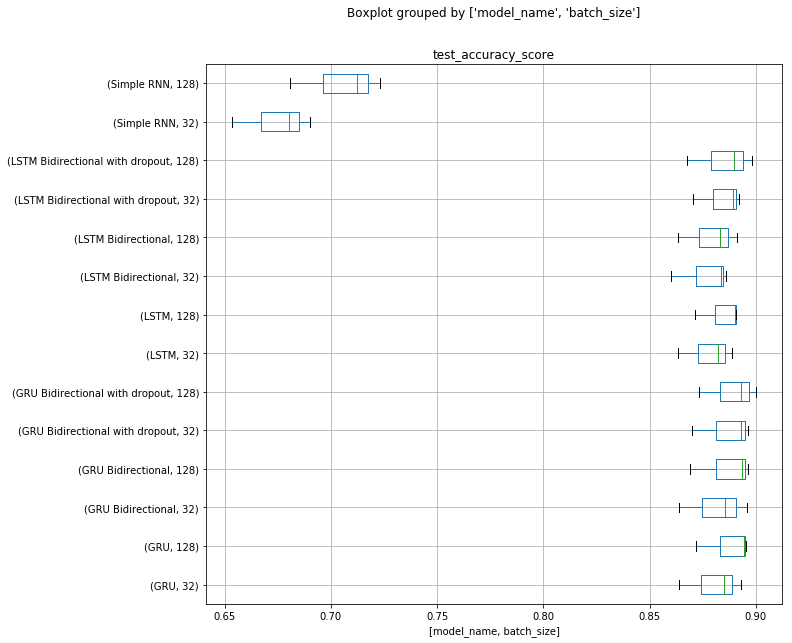

In [57]:
df_rnn_model_results2.boxplot(column = 'test_accuracy_score', by = ['model_name', 'batch_size'], vert = False, figsize=(10,10))
plt.show()

Compare model performance vs. number of words.

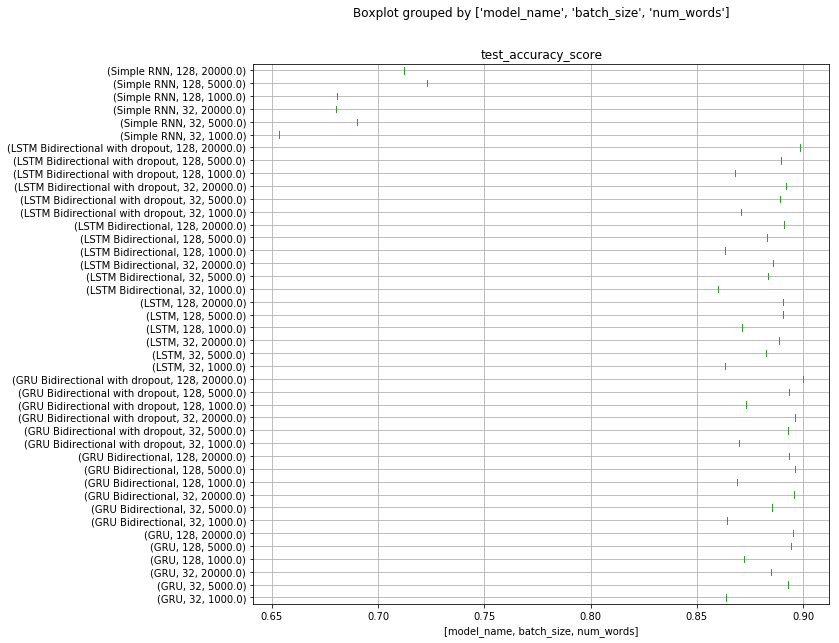

In [58]:
df_rnn_model_results2.boxplot(column = 'test_accuracy_score', by = ['model_name', 'batch_size', 'num_words'], vert = False, figsize=(10,10))
plt.show()

Compare model performance vs. batch size.

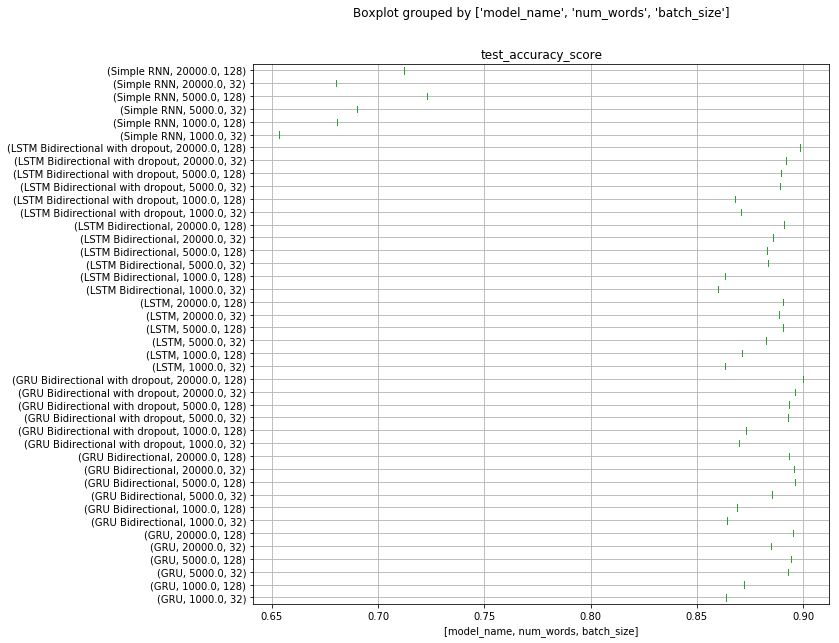

In [59]:
df_rnn_model_results2.boxplot(column = 'test_accuracy_score', by = ['model_name', 'num_words', 'batch_size',], vert = False, figsize=(10,10))
plt.show()

**Conclusions for RNN models' results:**

1. Usually batch size 128 gives better results than batch size 32, but batch size 128 takes much more time to estimate
2. Usually estimation on 20000 words gives within model type the best results (comparing to 1000 and 5000 words)
3. The best accuracy on test sample is reached by GRU Bidirectional with dropout model estimated on 128 batch size and 20000 words

## Compare classical models with RNN models

In [108]:
# Mark best estimation result for each model as model_rank = 1
df_rnn_model_results2['model_rank'] = df_rnn_model_results2.groupby(['model_name'])['test_accuracy_score'].rank(ascending=False)

df_classic_models_res2 = df_classic_models_res.copy()
df_classic_models_res2['model_rank'] = df_classic_models_res2.groupby(['model_name'])['mean_test_accuracy_score'].rank(ascending=False)
df_classic_models_res2.rename(columns={'mean_test_accuracy_score':'test_accuracy_score'}, inplace=True)

# Print best results for each model
df_model_comparison = pd.concat([df_rnn_model_results2[['model_rank', 'model_name', 'test_accuracy_score']], df_classic_models_res2[['model_rank', 'model_name', 'test_accuracy_score']]], axis=0)
df_model_comparison[df_model_comparison['model_rank']==1.].sort_values(['test_accuracy_score'], ascending=False)

,model_rank,model_name,test_accuracy_score
41,1.0,GRU Bidirectional with dropout,0.90000
35,1.0,LSTM Bidirectional with dropout,0.89840
25,1.0,GRU Bidirectional,0.89620
37,1.0,GRU,0.89520
33,1.0,LSTM Bidirectional,0.89100
31,1.0,LSTM,0.89060
10,1.0,LOG_REG,0.87850
68,1.0,xgboost,0.87070
30,1.0,svm,0.86905
14,1.0,svd_LOG_REG,0.85220


**Conclusion** <br>
Deep learning models on IMDB dataset perform better than classical models (except for Simple RNN)

## Data preparation for Kaggle

After finding which data preprocessing step and which models work the best for IMDB data set
repeat below all the steps above to score test data for Kaggle independent verification.

Prepare combined set (X_all = X_train + X_test).

In [79]:
X_all = kaggle_input_data_train.review
y_all = kaggle_input_data_train.sentiment

Dictionaries to store results.

In [80]:
kaggle_pipes = {}
kaggle_accuracy_score = {} #collects accuracy score on train data set
kaggle_roc_auc_score = {} #collects accuracy score on train data set
kaggle_predictions_on_kaggle_test_data = {} #dictionary of predictions to be send to Kaggle

Estimate best logistic regression model.

In [81]:
pipe_key = 'log_reg'

pipe = Pipeline([('noexpcontr_norempunc_noremsw_nostemmer', TextStemmer(expand_contractions=None, punctuation_list=None, stop_words_list=None, stemmer=None)),
                ('tfidvect5000', TfidfVectorizer(max_features=5000, min_df=0.001, max_df=0.5)),
                ('log_reg', LogisticRegression(C=1, penalty = 'l2'))
                ])
kaggle_pipes[pipe_key + "_trained_on_X_train"] = pipe.fit(X_train, y=y_train)
kaggle_accuracy_score[pipe_key + "_trained_on_X_train"] = accuracy_score(y_train, pipe.predict(X_train))
kaggle_roc_auc_score[pipe_key + "_trained_on_X_train"] = roc_auc_score(y_train, pipe.predict_proba(X_train)[:,1])

kaggle_predictions_on_kaggle_test_data[pipe_key + "_trained_on_X_train"] = pd.DataFrame(pipe.predict(kaggle_input_data_test.review), index=kaggle_input_data_test.index)


pipe = Pipeline([('noexpcontr_norempunc_noremsw_nostemmer', TextStemmer(expand_contractions=None, punctuation_list=None, stop_words_list=None, stemmer=None)),
                ('tfidvect5000', TfidfVectorizer(max_features=5000, min_df=0.001, max_df=0.5)),
                ('log_reg', LogisticRegression(C=1, penalty = 'l2'))
                ])
kaggle_pipes[pipe_key + "_trained_on_X_all"] = pipe.fit(X_all, y=y_all)
kaggle_accuracy_score[pipe_key + "_trained_on_X_all"] = accuracy_score(y_all, pipe.predict(X_all))
kaggle_roc_auc_score[pipe_key + "_trained_on_X_all"] = roc_auc_score(y_all, pipe.predict_proba(X_all)[:,1])
kaggle_predictions_on_kaggle_test_data[pipe_key + "_trained_on_X_all"] = pd.DataFrame(pipe.predict(kaggle_input_data_test.review), index=kaggle_input_data_test.index)

Show logistic regression accuracy score on train data sets.

In [82]:
print("Accuracy score:\n", kaggle_accuracy_score)
print("AUC ROC score:\n", kaggle_roc_auc_score)

Accuracy score:
 {'log_reg_trained_on_X_train': 0.91605, 'log_reg_trained_on_X_all': 0.91588}
AUC ROC score:
 {'log_reg_trained_on_X_train': 0.9736141, 'log_reg_trained_on_X_all': 0.9731373183999998}


Create embeddings matrices.

In [83]:
kaggle_rnn_embeddings = {}
kaggle_rnn_transformed_data = {}

pipe_data = Pipeline([('nostemmer_nosw_punc_expcontr', TextStemmer(stemmer=None, stop_words_list=None, punctuation_list=string.punctuation, expand_contractions = True)),
                ('rnn_tokenizer_20000', Rnn_Tokenizer(num_words=20000, max_seq_length=par_max_seq_length))])

kaggle_rnn_transformed_data['X_train'] = pipe_data.fit_transform(X_train, y_train)
kaggle_rnn_transformed_data['X_kaggle_trained_on_X_train'] = pipe_data.transform(kaggle_input_data_test.review)
kaggle_rnn_embeddings['X_train'] = create_embeddding_weights(pipe_data.steps[1][1].tokenizer, emb_words, emb_vectors)[0]


pipe_data = Pipeline([('nostemmer_nosw_punc_expcontr', TextStemmer(stemmer=None, stop_words_list=None, punctuation_list=string.punctuation, expand_contractions = True)),
                ('rnn_tokenizer_20000', Rnn_Tokenizer(num_words=20000, max_seq_length=par_max_seq_length))])

kaggle_rnn_transformed_data['X_all'] = pipe_data.fit_transform(X_all, y_all)
kaggle_rnn_transformed_data['X_kaggle_trained_on_X_all'] = pipe_data.transform(kaggle_input_data_test.review)
kaggle_rnn_embeddings['X_all'] = create_embeddding_weights(pipe_data.steps[1][1].tokenizer, emb_words, emb_vectors)[0]



Estimate best GRU model.

In [84]:
pipe_key = 'GRU'
bs = 128 #batch size
epochs = 100 #maximum number of epochs
y_data = {}
y_data["X_train"] = y_train
y_data["X_all"] = y_all

for data_key in ['X_train', 'X_all']:

    model = Sequential()
    model.add(Embedding(pipe_data.steps[1][1].tokenizer.num_words+1, par_embedding_length, input_length=par_max_seq_length, trainable=False, weights=[kaggle_rnn_embeddings[data_key]]))
    model.add(Bidirectional(GRU(100,dropout=0.3,recurrent_dropout=0.3)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

    early_stopping = EarlyStopping(patience=3, monitor="val_loss")
    take_best = ModelCheckpoint("weights.h5py", save_best_only=True)
    model.fit(kaggle_rnn_transformed_data[data_key], y_data[data_key], callbacks=[early_stopping, take_best], validation_split=0.25, batch_size=bs, epochs=epochs)

    model.load_weights("weights.h5py")
    os.remove("weights.h5py")
    kaggle_accuracy_score[pipe_key + "_trained_on_" + data_key] = model.evaluate(kaggle_rnn_transformed_data[data_key], y_data[data_key])[1]
    kaggle_roc_auc_score[pipe_key + "_trained_on_" + data_key] = roc_auc_score(y_data[data_key], model.predict_proba(kaggle_rnn_transformed_data[data_key]))
    kaggle_predictions_on_kaggle_test_data[pipe_key + "_trained_on_" + data_key] = pd.DataFrame(model.predict(kaggle_rnn_transformed_data['X_kaggle_trained_on_' + data_key]), index=kaggle_input_data_test.index[:len(kaggle_rnn_transformed_data['X_kaggle_trained_on_' + data_key])])

Train on 15000 samples, validate on 5000 samples
Epoch 1/100
15000/15000 [==============================] - 1174s 78ms/step - loss: 0.6236 - acc: 0.6457 - val_loss: 0.5107 - val_acc: 0.7402
Epoch 2/100
15000/15000 [==============================] - 1491s 99ms/step - loss: 0.4397 - acc: 0.7935 - val_loss: 0.3321 - val_acc: 0.8640
Epoch 3/100
15000/15000 [==============================] - 1557s 104ms/step - loss: 0.3543 - acc: 0.8495 - val_loss: 0.3043 - val_acc: 0.8778
Epoch 4/100
15000/15000 [==============================] - 1581s 105ms/step - loss: 0.3157 - acc: 0.8647 - val_loss: 0.2864 - val_acc: 0.8840
Epoch 5/100
15000/15000 [==============================] - 1567s 104ms/step - loss: 0.2979 - acc: 0.8736 - val_loss: 0.2976 - val_acc: 0.8788
Epoch 6/100
15000/15000 [==============================] - 1469s 98ms/step - loss: 0.2744 - acc: 0.8874 - val_loss: 0.2829 - val_acc: 0.8872
Epoch 7/100
15000/15000 [==============================] - 1496s 100ms/step - loss: 0.2563 - acc: 0.89

Output data for Kaggle competition.

In [85]:
for dict_key, kagle_pred in kaggle_predictions_on_kaggle_test_data.items():
    kaggle_predictions_on_kaggle_test_data[dict_key].columns = ['sentiment']
    kaggle_predictions_on_kaggle_test_data[dict_key].to_csv('02 Output data/kaggle_pred_' + dict_key + '.csv')

Csv files created above are sent to Kaggle for independent verification.

In [94]:
# Show models' metrics on train sets
kaggle_results = pd.concat([pd.Series(kaggle_accuracy_score, name = 'train_accuracy_score'), pd.Series(kaggle_roc_auc_score, name='train_roc_auc_score')], axis = 1)

# Value of roc_auc_score calculated by Kaggle are written below by hand in a code
kaggle_results = kaggle_results.assign(kaggle_roc_auc_score = pd.Series({
    "log_reg_trained_on_X_train":0.88140,
    "log_reg_trained_on_X_all": 0.88176,
    "GRU_trained_on_X_train":0.96035,
    "GRU_trained_on_X_all":0.96446}))

kaggle_results

,train_accuracy_score,train_roc_auc_score,kaggle_roc_auc_score
log_reg_trained_on_X_train,0.91605,0.973614,0.88140
log_reg_trained_on_X_all,0.91588,0.973137,0.88176
GRU_trained_on_X_train,0.93630,0.981974,0.96035
GRU_trained_on_X_all,0.94392,0.985081,0.96446


ROC_AUC value equal to 0.96446 gives 39 position in Kaggle tutorial competition leader board (among 528 teams) <br>
Link for the tutorial competition: <br>
https://www.kaggle.com/c/word2vec-nlp-tutorial

## Final conclusions

#### Classical models:

1. The best model among classical models is Logistic Regression which is slightly surprising. 
2. XGBoost and SVM are slightly worse (SVM is calculated on 500 variables resulting from SVD decomposition).
3. It is possible that better tuning of hyperparameters for XGBoost and SVM could result in better performance (at least reaching logistic regression level).
4. Using SVD to preselect variables for Logistic Regression gives unsatisfactory results.
5. Logistic regression gives the best test accuracy score (0.87850)
6. Using 1000 words as a base for estimation gives noticeable worse result than estimation on 5000 most popular words.
7. Preprocessing data (expanding contraction, removing punctuation and stop words and using stemmer) gives slightly worse performance than data which are not preprocessed in any way.
8. Using count vectorizer gives slightly worse performance than using TFidf Vectorizer.


#### RNN models:

1. Usually batch size 128 gives better results than batch size 32, but batch size 128 takes much more time to estimate.
2. Usually estimation on 20000 words gives within model type the best results (comparing to 1000 and 5000 words).
3. The best accuracy (0.90000) on test sample is reached by GRU Bidirectional with dropout model estimated on 128 batch size and 20000 words.

#### Classical models vs RNN models:

1. Deep learning models on IMDB dataset perform better than classical models (except for Simple RNN).

#### Kaggle tutorial competition:

1. ROC_AUC value equal to 0.96446 (from GRU Bidirectional with dropout model) gives 39 position in Kaggle tutorial competition leader board (among 528 teams).
2. ROC_AUC for Logistic regression model is 0.88176 which is significantly worse than result from GRU Bidirectional with dropout model (0.96446).